# Chainerを用いたニューラルネットワーク

### まずはとりあえずおまじない

In [2]:
import numpy as np
import chainer
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from __future__ import print_function

#可視化用
from IPython.display import Image
import matplotlib.pyplot as plt

### Chainerについて  
ディープラーニングを手軽に試せるツールとして、Chainerはおすすめ(らしい)。導入のしやすさに加え、[Trainer](https://docs.chainer.org/en/stable/glance.html#trainer-structure)という機能によってシンプルなコーディングでディープラーニングで必要な様々なことが可能になる。TrainerのUIサポート([ChainerUI](http://chainerui.readthedocs.io/en/latest/index.html))なんてのもある。  
ディープラーニングは様々なハイパーパラメータが存在しており、よほどのプロでない限り与えられたデータに対して正しいアプローチを見つけ出すのは容易ではない。ChainerではTrainerの拡張機能によって学習中のコスト関数やパラメータ、汎化性能の値や挙動を常時モニタリングでき、ビギナーにとって感覚がつかみやすい仕様となっている。(~~まあ、TensorFlowにもあるらしいけれど~~)  
**注**:以下の例を見る前に、Trainerのリンクからその構造をなんとなく理解しておくべし。

### Datasets  
今回はCIFAR-10を用いる。ダウンロードしていない場合も自動でダウンロードしてくれる。  
データセットのうち9割をtrainに、残りをvalidationに分ける。

In [3]:
from chainer.datasets import cifar
from chainer.datasets import split_dataset_random

train_val, test = cifar.get_cifar10()

train_size = int(len(train_val) * 0.9)
train, valid = split_dataset_random(train_val, train_size, seed=0)

### ネットワークの定義  
続いて、自分なりに構築したモデルをclass MyNetとして定義する。chainerでは(重みなどの)パラメータを持つ層をLink,持たない層をFunctionと  
二つに分けて記述する。  
私は(Convolution→Pooling)×4→Fully connected×2という構造のネットワークにしてみた。

In [4]:
class MyNet(chainer.Chain):

    def __init__(self, n_out=10):
        super(MyNet, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 32, 3, 3, 1)
            self.conv2 = L.Convolution2D(32, 64, 3, 3, 1)
            self.conv3 = L.Convolution2D(64, 128, 3, 3, 1)
            self.conv4 = L.Convolution2D(128, 128, 3, 3, 1)
            self.conv5 = L.Convolution2D(128, 128, 3, 3, 1)
            self.fc6 = L.Linear(None, 1000)
            self.fc7 = L.Linear(1000, n_out)
            self.bn1 = L.BatchNormalization(32)
            self.bn2 = L.BatchNormalization(64)
            self.bn3 = L.BatchNormalization(128)
            self.bn4 = L.BatchNormalization(128)
            self.bn5 = L.BatchNormalization(128)
            self.bn6 = L.BatchNormalization(1000)
            

    def __call__(self, x):
        h = F.max_pooling_2d(F.relu(self.bn1(self.conv1(x))), 2)
        h = F.max_pooling_2d(F.relu(self.bn2(self.conv2(h))), 2)
        h = F.max_pooling_2d(F.relu(self.bn3(self.conv3(h))), 2)
        h = F.max_pooling_2d(F.relu(self.bn4(self.conv4(h))), 2)
        h = F.max_pooling_2d(F.relu(self.bn5(self.conv5(h))), 2)      
        h = F.relu(self.bn6(self.fc6(h)))
        h = self.fc7(h)
        return h

### Model  
Optimizerに渡すModelはGPUで計算する。

In [5]:
model = MyNet()

gpu_id = 0 #NOTE:CPUで計算する場合、-1に設定

if gpu_id >= 0:
    model.to_gpu(gpu_id)

model = L.Classifier(model) #Classifierという名前がついているが、loss functionを変えることで回帰にも使うことができる。loss functionのデフォルトはsoftmax_cross_entropy。

### Iterator

In [6]:
batchsize = 128 #ミニバッチのサイズ

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, False, False)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

### Optimizer

In [7]:
optimizer = optimizers.AdaGrad(lr=0.01) #AdaGradを最適化法として選択

optimizer.setup(model) #optimizerにmodelを参照させる

### Updater

In [8]:
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

### Trainer/Extensions

In [13]:
max_epoch=30

trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='cifar10_result')

trainer.extend(extensions.LogReport())
trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id), name='validation')
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

### 実行

In [14]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.19126     0.578125       1.38703               0.498242                  1.2203        
2           1.29022     0.535536       1.31039               0.520898                  10.9162       
3           1.19302     0.56891        1.31086               0.532617                  20.4534       
4           1.12371     0.595059       1.24243               0.554883                  29.1053       
5           1.06992     0.614049       1.2434                0.55957                   37.6462       
6           1.02256     0.630815       1.20956               0.569922                  46.2414       
7           0.982743    0.647258       1.20849               0.570898                  55.5979       
8           0.945113    0.659513       1.22202               0.57168                   65.1957       
9           0.913888    0.671431       1.20769               0.575195               

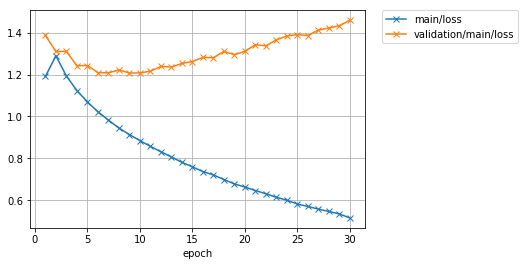

In [15]:
Image(filename='cifar10_result/loss.png')

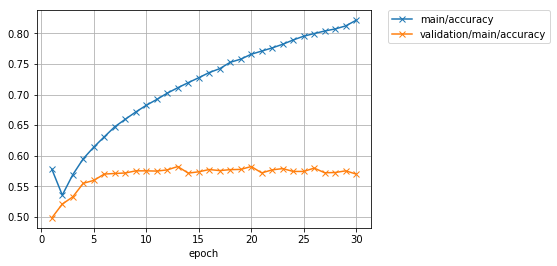

In [16]:
Image(filename='cifar10_result/accuracy.png')

In [17]:
test_evaluator = extensions.Evaluator(test_iter, model, device=gpu_id)
results = test_evaluator()
print('Test accuracy:', results['main/accuracy'])

Test accuracy: 0.5774327516555786


過学習してる...(泣)次回は拡張機能(trainer.extend)等を触りながら、より良いモデルチューニングしていく。